In [ ]:
# ! pip install pydot 
# ! pip install graphviz

In [3]:
# Import the required libraries.
import os
import cv2
# !pip install pafy
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [4]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [5]:
# # Create a Matplotlib figure and specify the size of the figure.
# plt.figure(figsize = (20, 20))

# # Get the names of all classes/categories in UCF50.
# #all_classes_names = os.listdir('dataset/UCF50')

# # Generate a list of 20 random values. The values will be between 0-50,
# # where 50 is the total number of class in the dataset.
# random_range = random.sample(range(len(all_classes_names)), 20)

# # Iterating through all the generated random values.
# for counter, random_index in enumerate(random_range, 1):

#     # Retrieve a Class Name using the Random Index.
#     selected_class_Name = all_classes_names[random_index]

#     # Retrieve the list of all the video files present in the randomly selected Class Directory.
#     video_files_names_list = os.listdir(f'dataset/UCF50/{selected_class_Name}')

#     # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
#     selected_video_file_name = random.choice(video_files_names_list)

#     # Initialize a VideoCapture object to read from the video File.
#     video_reader = cv2.VideoCapture(f'dataset/UCF50/{selected_class_Name}/{selected_video_file_name}')

#     # Read the first frame of the video file.
#     _, bgr_frame = video_reader.read()

#     # Release the VideoCapture object.
#     video_reader.release()

#     # Convert the frame from BGR into RGB format.
#     rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

#     # Write the class name on the video frame.
#     cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

#     # Display the frame.
#     plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

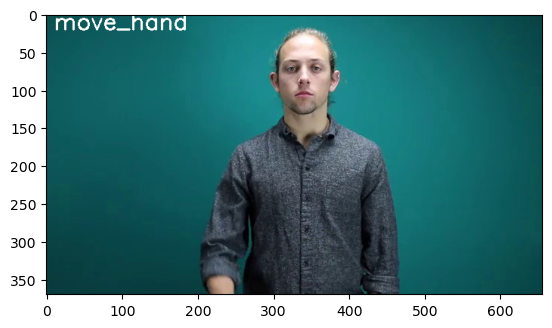

In [6]:
video_reader = cv2.VideoCapture(r'T:\sem_capstone\asl_videoData\sorted_frames\a\66039_8.jpg')
_, bgr_frame = video_reader.read()
video_reader.release()
rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
cv2.putText(rgb_frame, 'move_hand', (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
plt.imshow(rgb_frame)

In [7]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 240, 240

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 1

In [8]:
def new_extraction(path):
  frames_list = []

  # Read the Video File using the VideoCapture object.
  video_reader = cv2.VideoCapture(path)

  # Get the total number of frames in the video.
  video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
  
  # Calculate the the interval after which frames will be added to the list.
  skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

  # Iterate through the Video Frames.
  for frame_counter in range(SEQUENCE_LENGTH):

      # Set the current frame position of the video.
      video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

      # Reading the frame from the video.
      success, frame = video_reader.read()

      # Check if Video frame is not successfully read then break the loop
      if not success:
        break

      # Resize the Frame to fixed height and width.
      resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

      # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
      normalized_frame = resized_frame / 255

      # Append the normalized frame into the frames list
      frames_list.append(normalized_frame)

      # Release the VideoCapture object.
      video_reader.release()

      # Return the frames list.
      print(frames_list)
  return frames_list

In [9]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    # Return the frames list.
    return frames_list

In [10]:
import os
import cv2
import numpy as np

# Specify the base directory where the video files are located
base_dir = r'T:\sem_capstone\asl_videoData\videos'

video_files_paths = []
labels = []
features = []
# li = ['drink','computer','no', 'yes', 'clothes', 'thankyou', 'book', 'before']
# List of video IDs for each label
# label_0_video_ids = [69302, 65539, 17710, 17733, 17711, 17713]
label_0_video_ids = [69302, 65539, 17710, 17733, 65540, 
                     17734, 17711, 17713, 17709, 17720,
                     17721, 17722, 17723, 17724] # drink
# label_1_video_ids = [12328, 12312, 12311, 12338, 12313, 12314]
label_1_video_ids = [12328, 12312, 12311, 12338, 12313, 
                     12314, 12315, 12316, 12317, 12318, 
                     12319, 12320, 12326, 12327] # computer
# label_2_video_ids = [69411, 38525, 38529, 38530, 38532, 38533]
# label_2_video_ids = [69411,  38525, 38544, 38527, 38529, 38530, 38532, 38533, 66183, 
#                      38524,  38534]
# label_3_video_ids = [69546, 64287, 64284, 64291, 64292, 64293, 66820, 64280]
# label_3_video_ids = [69546, 64287, 64284, 64291, 64292,  
#                      64293, 66820, 64280, 
#                      64300, 64281, 64288, 64283]
# label_4_video_ids = [11310, 11330, 11311, 11313, 11309]
# # label_4_video_ids = [11310, 11330, 
# #                      11311, 11313, 11309]
# label_5_video_ids = [69502, 57663, 66598, 57655, 57667]
# label_5_video_ids = [69502, 57663, 66598, 57655, 57667, 57656, 57657, 57659]

# label_6_video_ids = ["69241", "07069", "07068", "07070", "07099", "07074"] # book
label_7_video_ids = ["05728", "05749", "05750", "05729", "05730", 
                     "65167", "05731", "05732", "05733", "05734", 
                     "05727", "05739", "05742", "05743"]
# label_7_video_ids = ["05728", "05749", "05750", "05729", "05730", 
#                      "65167", "05731", "05732", "05733", "05734", 
#                      "05727", "05737", "05739", "05740", "05741", 
#                      "05742", "05743"] # before
label_8_video_ids = ["69345", "24955", "24956", "24941", "24960", 
                     "24961", "24962", "65824", "24973", "24943", 
                     "24946", "24947", "24940", "24952"]
# label_8_video_ids = ["69345", "24955", "24956", "24941", "24960", 
#                      "24961", "24962", "65824", "24973", "24943", 
#                      "24946", "24947", "24940", "24952", "24954"] # go


# Loop through each label and corresponding video IDs
for label, video_ids in enumerate([label_0_video_ids, label_1_video_ids, label_7_video_ids, label_8_video_ids]):
    for video_id in video_ids:
        file_name = f"{video_id}.mp4"
        file_path = os.path.join(base_dir, file_name)
        
        # Check if the file exists in the base directory
        if os.path.isfile(file_path):
            video_files_paths.append(file_path)
            labels.append(label)
            
            # Extract frames from the video file
            frames = frames_extraction(file_path)
            
            # Check if the extracted frames are equal to the SEQUENCE_LENGTH
            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
            else:
                print(f"Skipping {file_path}: Incorrect number of frames")
        else:
            print(f"File not found: {file_path}")

# Convert features and labels to numpy arrays
features = np.asarray(features)
labels = np.array(labels)

# Print the generated file paths, labels, and number of features
# print("Video file paths:")
# for path in video_files_paths:
#     print(path)


print("\nLabels:")
print(labels)

print(f"\nNumber of features: {len(features)}")



Labels:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3]

Number of features: 56


In [11]:
# features = []
# labels = [0,0,0,0,0,1,1,1,1,1,2,2,2,2]
# video_files_paths = [r'T:\sem_capstone\asl_videoData\videos\07068.mp4',r'T:\sem_capstone\asl_videoData\videos\07069.mp4',r'T:\sem_capstone\asl_videoData\videos\07070.mp4',r'T:\sem_capstone\asl_videoData\videos\07074.mp4',r'T:\sem_capstone\asl_videoData\videos\07099.mp4',r'T:\sem_capstone\asl_videoData\videos\38011.mp4',r'T:\sem_capstone\asl_videoData\videos\38012.mp4',r'T:\sem_capstone\asl_videoData\videos\38013.mp4',r'T:\sem_capstone\asl_videoData\videos\38014.mp4',r'T:\sem_capstone\asl_videoData\videos\38015.mp4',r'T:\sem_capstone\asl_videoData\videos\60220.mp4',r'T:\sem_capstone\asl_videoData\videos\60224.mp4',r'T:\sem_capstone\asl_videoData\videos\60225.mp4']
# # Iterate through all the files present in the files list.
# for file_name in video_files_paths:

#     # Extract the frames of the video file.
#     frames = new_extraction(file_name)
#     print(len(frames))

#     # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
#     # So ignore the vides having frames less than the SEQUENCE_LENGTH.
#     if len(frames) == SEQUENCE_LENGTH:

#         # Append the data to their repective lists.
#         features.append(frames)

#     # Converting the list to numpy arrays
# features = np.asarray(features)
# labels = np.array(labels)


In [12]:
# video_files_paths_1 = r'T:\sem_capstone\asl_videoData\videos\07068.mp4'
# frames_1 = new_extraction(video_files_paths_1)
# features_1 = np.asarray(frames_1)

In [13]:
one_hot_encoded_labels = to_categorical(labels)

In [14]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))

    model.add(Flatten())

    model.add(Dense(4, activation = "softmax"))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed convlstm model.
    return model

In [15]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 1, 238, 238, 4)    1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 1, 119, 119, 4)   0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 1, 119, 119, 4)   0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 1, 117, 117, 8)    3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 1, 59, 59, 8)     0         
 3D)                                                             
                                                        

In [16]:
# Plot the structure of the contructed model.
# plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [17]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 20, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = features, y = one_hot_encoded_labels, epochs = 50, batch_size = 4,
                                                     shuffle = True, validation_split = 0.3,
                                                     callbacks = [early_stopping_callback])

Epoch 1/50
10/10 [==============================] - 13s 606ms/step - loss: 1.3806 - accuracy: 0.1282 - val_loss: 1.4431 - val_accuracy: 0.0000e+00
Epoch 2/50
10/10 [==============================] - 5s 530ms/step - loss: 1.3167 - accuracy: 0.3333 - val_loss: 1.9138 - val_accuracy: 0.0000e+00
Epoch 3/50
10/10 [==============================] - 5s 531ms/step - loss: 1.1590 - accuracy: 0.3590 - val_loss: 4.4290 - val_accuracy: 0.0000e+00
Epoch 4/50
10/10 [==============================] - 5s 537ms/step - loss: 1.0867 - accuracy: 0.3077 - val_loss: 6.9695 - val_accuracy: 0.0000e+00
Epoch 5/50
10/10 [==============================] - 5s 529ms/step - loss: 1.1134 - accuracy: 0.4872 - val_loss: 8.0856 - val_accuracy: 0.0000e+00
Epoch 6/50
10/10 [==============================] - 5s 520ms/step - loss: 0.9993 - accuracy: 0.4615 - val_loss: 9.0590 - val_accuracy: 0.0000e+00
Epoch 7/50
10/10 [==============================] - 5s 507ms/step - loss: 0.9899 - accuracy: 0.4615 - val_loss: 10.8636 - v

In [18]:
li = ['drink','computer', 'before', 'go']

In [19]:
def predict_single_action(video_file_path, SEQUENCE_LENGTH):
    """
    This function will perform single action recognition prediction on a video using the LRCN model.
    Args:
    video_file_path: The path of the video stored in the disk on which the action recognition is to be performed.
    SEQUENCE_LENGTH: The fixed number of frames of a video that can be passed to the model as one sequence.
    """
    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Declare a list to store video frames we will extract.
    frames_list = []

    # Get the number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

    # Iterating the number of times equal to the fixed length of sequence.
    for frame_counter in range(SEQUENCE_LENGTH):
        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Read a frame.
        success, frame = video_reader.read()

        # Check if frame is not read properly then break the loop.
        if not success:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list
        frames_list.append(normalized_frame)

    # Passing the pre-processed frames to the model and get the predicted probabilities.
    predicted_labels_probabilities = convlstm_model.predict(np.expand_dims(frames_list, axis=0))[0]

    # Loop through each class and print the predictions
    for class_index, class_name in enumerate(li):
        predicted_probability = predicted_labels_probabilities[class_index]
        print(f'Action Predicted: {class_name}\nConfidence: {predicted_probability}')

    # Release the VideoCapture object.
    video_reader.release()

In [20]:
# Construct tihe nput youtube video path
input_video_file_path = r"T:\sem_capstone\asl_videoData\videos\24954.mp4"

# Perform Single Prediction on the Test Video.
predict_single_action(input_video_file_path, SEQUENCE_LENGTH)

# Display the input video.
VideoFileClip(input_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

1/1 [==============================] - 1s 668ms/step
Action Predicted: drink
Confidence: 0.25684216618537903
Action Predicted: computer
Confidence: 0.25677815079689026
Action Predicted: before
Confidence: 0.2551029324531555
Action Predicted: go
Confidence: 0.2312767654657364
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [21]:
# label_0_video_ids = [69302, 65539, 17710, 17733, 17711, 17713, 17709, 17720, 17722, 17723]
# # label_0_video_ids = [69302, 65539, 17710, 17733, 65540, 
# #                      17734, 17711, 17713, 17709, 17720, 17721, 
# #                      17722, 17723, 17724]
# label_1_video_ids = [12328, 12312, 12311, 12338, 12313, 12314, 12315, 12316, 12317, 12318]
# # label_1_video_ids = [12328,  12312,  12311, 12338, 
# #                      12313, 12314, 12315, 12316, 12317, 12318, 
# #                      12319, 12320, 12326, 12327]
# label_2_video_ids = [69411, 38525, 38529, 38530, 38532, 38533, 38530, 66183, 38524, 38534]
# # label_2_video_ids = [69411,  38525, 38544, 38527, 38529, 38530, 38532, 38533, 66183, 
# #                      38524,  38534]

## Pre-Trained Model   
 - Resnet50
 - InceptionV3

### Resnet50

In [22]:
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.layers import Dense, Dropout, Flatten, TimeDistributed
from keras.models import Sequential
import numpy as np

def create_convlstm_model_resnet50():
    """
    This function will construct the required ConvLSTM2D model using transfer learning.
    Returns:
        model: The constructed ConvLSTM2D model.
    """
    # Load the pre-trained ResNet50 model
    base_model_resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

    # Freeze the pre-trained layers
    for layer in base_model_resnet50.layers:
        layer.trainable = False

    # Construct the model
    model = Sequential()
    model.add(TimeDistributed(base_model_resnet50, input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(len(li), activation='softmax'))

    # Display the model summary
    model.summary()

    return model

# Create an instance of the ConvLSTM2D model
convlstm_model_resnet50 = create_convlstm_model_resnet50()

# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 20, mode = 'min', restore_best_weights = True)

# Compile the model
convlstm_model_resnet50.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
convlstm_model_training_history_resnet50 = convlstm_model_resnet50.fit(x=features, y=one_hot_encoded_labels, epochs=50, 
                                                                       batch_size=4, shuffle=True, validation_split=0.3, 
                                                                       callbacks=[early_stopping_callback])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, 1, 8, 8, 2048)    23587712  
 tributed)                                                       
                                                                 
 flatten_1 (Flatten)         (None, 131072)            0         
                                                                 
 dense_1 (Dense)             (None, 128)               16777344  
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 4)                 516       
                                                                 
Total params: 40,365,572
Trainable params: 16,777,860
Non-trainable params: 23,587,712
_________________________________

### InceptionV3

In [23]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.layers import Dense, Dropout, Flatten, TimeDistributed
from keras.models import Sequential
import numpy as np
def create_convlstm_model_inceptionv3():
    """
    This function will construct the required ConvLSTM2D model using transfer learning.
    Returns:
        model: The constructed ConvLSTM2D model.
    """
    # Load the pre-trained ResNet50 model
    base_model_inceptionv3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), classes = 2)

    # Freeze the pre-trained layers
    for layer in base_model_inceptionv3.layers:
        layer.trainable = False

    # Construct the model
    model = Sequential()
    model.add(TimeDistributed(base_model_inceptionv3, input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(len(li), activation='softmax'))

    # Display the model summary
    model.summary()

    return model

# Create an instance of the ConvLSTM2D model
convlstm_model_inceptionv3 = create_convlstm_model_inceptionv3()

# Compile the model
convlstm_model_inceptionv3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
convlstm_model_training_history_inceptionV3 = convlstm_model_inceptionv3.fit(x=features, y=one_hot_encoded_labels, epochs=50, batch_size=4, shuffle=True, validation_split=0.3, callbacks=[early_stopping_callback])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 1, 6, 6, 2048)    21802784  
 tributed)                                                       
                                                                 
 flatten_2 (Flatten)         (None, 73728)             0         
                                                                 
 dense_3 (Dense)             (None, 512)               37749248  
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 59,554,084
Trainable params: 37,751,300
Non-trainable params: 21,802,784
_________________________________

In [24]:
# # li = ['drink','computer','no', 'yes', 'clothes', 'thankyou', 'book', 'before']
# # List of video IDs for each label
# # label_0_video_ids = [69302, 65539, 17710, 17733, 17711, 17713]
# label_0_video_ids = [69302, 65539, 17710, 17733, 65540, 
#                      17734, 17711, 17713, 17709, 17720,
#                      17721, 17722, 17723, 17724] # drink
# # label_1_video_ids = [12328, 12312, 12311, 12338, 12313, 12314]
# label_1_video_ids = [12328, 12312, 12311, 12338, 12313, 
#                      12314, 12315, 12316, 12317, 12318, 
#                      12319, 12320, 12326, 12327] # computer
# # label_2_video_ids = [69411, 38525, 38529, 38530, 38532, 38533]
# # label_2_video_ids = [69411,  38525, 38544, 38527, 38529, 38530, 38532, 38533, 66183, 
# #                      38524,  38534]
# # label_3_video_ids = [69546, 64287, 64284, 64291, 64292, 64293, 66820, 64280]
# # label_3_video_ids = [69546, 64287, 64284, 64291, 64292,  
# #                      64293, 66820, 64280, 
# #                      64300, 64281, 64288, 64283]
# # label_4_video_ids = [11310, 11330, 11311, 11313, 11309]
# # # label_4_video_ids = [11310, 11330, 
# # #                      11311, 11313, 11309]
# # label_5_video_ids = [69502, 57663, 66598, 57655, 57667]
# # label_5_video_ids = [69502, 57663, 66598, 57655, 57667, 57656, 57657, 57659]

# # label_6_video_ids = ["69241", "07069", "07068", "07070", "07099", "07074"] # book
# label_7_video_ids = ["05728", "05749", "05750", "05729", "05730", 
#                      "65167", "05731", "05732", "05733", "05734", 
#                      "05727", "05739", "05742", "05743"]
# # label_7_video_ids = ["05728", "05749", "05750", "05729", "05730", 
# #                      "65167", "05731", "05732", "05733", "05734", 
# #                      "05727", "05737", "05739", "05740", "05741", 
# #                      "05742", "05743"] # before
# label_8_video_ids = ["69345", "24955", "24956", "24941", "24960", 
#                      "24961", "24962", "65824", "24973", "24943", 
#                      "24946", "24947", "24940", "24952"]
# # label_8_video_ids = ["69345", "24955", "24956", "24941", "24960", 
# #                      "24961", "24962", "65824", "24973", "24943", 
# #                      "24946", "24947", "24940", "24952", "24954"] # go

## Resnet50 prediction

In [25]:
def predict_single_action_resnet50(input_video_file_path_resnet50, SEQUENCE_LENGTH):
    """
    This function will perform single action recognition prediction on a video using the LRCN model.
    Args:
    video_file_path: The path of the video stored in the disk on which the action recognition is to be performed.
    SEQUENCE_LENGTH: The fixed number of frames of a video that can be passed to the model as one sequence.
    """
    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(input_video_file_path_resnet50)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Declare a list to store video frames we will extract.
    frames_list = []

    # Get the number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

    # Iterating the number of times equal to the fixed length of sequence.
    for frame_counter in range(SEQUENCE_LENGTH):
        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Read a frame.
        success, frame = video_reader.read()

        # Check if frame is not read properly then break the loop.
        if not success:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list
        frames_list.append(normalized_frame)

    # Passing the pre-processed frames to the model and get the predicted probabilities.
    predicted_labels_probabilities = convlstm_model_resnet50.predict(np.expand_dims(frames_list, axis=0))[0]

    # Loop through each class and print the predictions 
    for class_index, class_name in enumerate(li):
        predicted_probability = predicted_labels_probabilities[class_index]
        print(f'Action Predicted: {class_name}\nConfidence: {predicted_probability}')
        
    # Release the VideoCapture object.
    video_reader.release()

In [26]:
# Construct tihe nput youtube video path
input_video_file_path_resnet50 = r"T:\sem_capstone\asl_videoData\videos\05749.mp4"

# Perform Single Prediction on the Test Video.
predict_single_action_resnet50(input_video_file_path_resnet50, SEQUENCE_LENGTH)

# Display the input video.
VideoFileClip(input_video_file_path_resnet50, audio=False, target_resolution=(300,None)).ipython_display()

1/1 [==============================] - 3s 3s/step
Action Predicted: drink
Confidence: 0.2510152757167816
Action Predicted: computer
Confidence: 0.2533341646194458
Action Predicted: before
Confidence: 0.25188490748405457
Action Predicted: go
Confidence: 0.24376563727855682
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


## InceptionV3 prediction

In [27]:
def predict_single_action_inceptionv3(video_file_path, SEQUENCE_LENGTH):
    """
    This function will perform single action recognition prediction on a video using the LRCN model.
    Args:
    video_file_path: The path of the video stored in the disk on which the action recognition is to be performed.
    SEQUENCE_LENGTH: The fixed number of frames of a video that can be passed to the model as one sequence.
    """
    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Declare a list to store video frames we will extract.
    frames_list = []

    # Get the number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

    # Iterating the number of times equal to the fixed length of sequence.
    for frame_counter in range(SEQUENCE_LENGTH):
        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Read a frame.
        success, frame = video_reader.read()

        # Check if frame is not read properly then break the loop.
        if not success:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list
        frames_list.append(normalized_frame)

    # Passing the pre-processed frames to the model and get the predicted probabilities.
    predicted_labels_probabilities = convlstm_model_inceptionv3.predict(np.expand_dims(frames_list, axis=0))[0]

    # Loop through each class and print the predictions
    for class_index, class_name in enumerate(li):
        predicted_probability = predicted_labels_probabilities[class_index]
        print(f'Action Predicted: {class_name}\nConfidence: {predicted_probability}')
        
    # Release the VideoCapture object.
    video_reader.release()

In [28]:
# # label_7_video_ids = ["05728", "05749", "05750", "05729", "05730", 
# #                      "65167", "05731", "05732", "05733", "05734", 
# #                      "05727", "05737", "05739", "05740", "05741", 
# #                      "05742", "05743"]

In [29]:
# before 
# right prediction: 05728, 05749, 05750, 05729, 05730, 65167, 05731, 05732, 05733, 05734, 05727
# wrong prediction: 05739, 05740, 05741, 05742, 05743
# wrong prediction might be because of image quality. As i have consider fixed image height and width. 
# Blur(resizing)

In [30]:
# # label_8_video_ids = ["69345", "24955", "24956", "24941", "24960", 
# #                      "24961", "24962", "65824", "24973", "24943", 
# #                      "24946", "24947", "24940", "24952", "24954"]

In [31]:
# Go 
# right prediction: 
# wrong prediction: 69345, 24955, 24956, 24941, 24960, 24961, 24962, 24973, 24940

In [32]:
# Construct tihe nput youtube video path
input_video_file_path_inceptionv3 = "T:\\sem_capstone\\asl_videoData\\videos\\24954.mp4"

# Perform Single Prediction on the Test Video.
predict_single_action_inceptionv3(input_video_file_path_inceptionv3, SEQUENCE_LENGTH)

# Display the input video.
VideoFileClip(input_video_file_path_inceptionv3, audio=False, target_resolution=(300,None)).ipython_display()

1/1 [==============================] - 4s 4s/step
Action Predicted: drink
Confidence: 1.0
Action Predicted: computer
Confidence: 0.0
Action Predicted: before
Confidence: 0.0
Action Predicted: go
Confidence: 0.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


### Saving InceptionV3 model

In [41]:
# Define the path to save the model
model_path = 'inceptionv3_model.h5'

# Save the model
convlstm_model_inceptionv3.save(model_path)

print("Model saved successfully at:", model_path)


Model saved successfully at: inceptionv3_model.h5


### Streamlit libraries

In [30]:
import streamlit as st
from streamlit_webrtc import webrtc_streamer
import av
from tensorflow.keras.models import load_model

In [31]:
# # Load the saved InceptionV3 model
# model_path = 'inceptionv3_model.h5'
# inception_model = load_model(model_path)

# def main():
#     st.title("InceptionV3 Video Classification")

#     video_file = st.file_uploader("Upload video file", type=["mp4", "avi"])

#     if video_file is not None:
#         st.video(video_file)
#         cap = cv2.VideoCapture(video_file)

#         while cap.isOpened():
#             ret, frame = cap.read()
#             if not ret:
#                 break

#             predictions = predict_single_action_inceptionv3(video_file, SEQUENCE_LENGTH)

#             # Display predictions
#             st.write("Predictions:", predictions)

#             # Display video frame
#             st.image(frame, channels="BGR", use_column_width=True)
            
# if __name__ == "__main__":
#     main()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_7 (TimeDis  (None, 1, 8, 8, 2048)    23587712  
 tributed)                                                       
                                                                 
 flatten_5 (Flatten)         (None, 131072)            0         
                                                                 
 dense_9 (Dense)             (None, 128)               16777344  
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 4)                 516       
                                                                 
Total params: 40,365,572
Trainable params: 16,777,860
Non-trainable params: 23,587,712
_________________________________

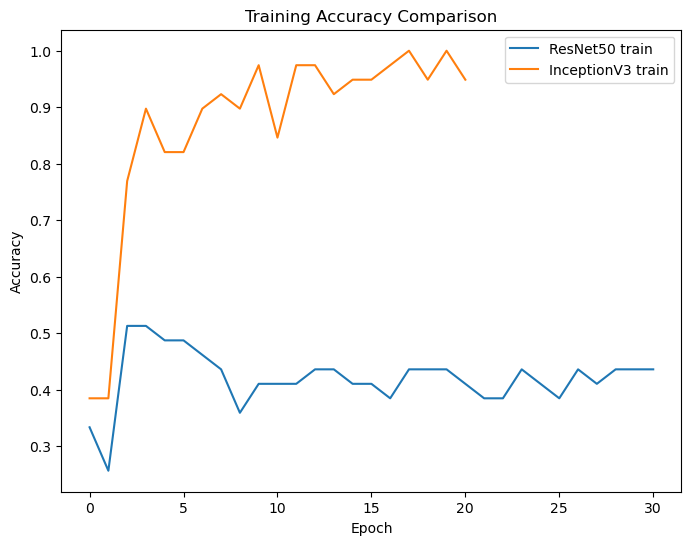

In [34]:
import matplotlib.pyplot as plt

def plot_training_accuracy(convlstm_model_training_history_resnet50, convlstm_model_training_history_inceptionv3):
    """
    This function will plot the training accuracy for both the ResNet50-based and InceptionV3-based models.
    Args:
        convlstm_model_training_history_resnet50: The training history object for the ResNet50-based model.
        convlstm_model_training_history_inceptionv3: The training history object for the InceptionV3-based model.
    """
    # Plot the training accuracy
    plt.figure(figsize=(8, 6))
    plt.plot(convlstm_model_training_history_resnet50.history['accuracy'], label='ResNet50 train')
    plt.plot(convlstm_model_training_history_inceptionv3.history['accuracy'], label='InceptionV3 train')
    plt.title('Training Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Train the ResNet50-based model
convlstm_model_resnet50 = create_convlstm_model_resnet50()
convlstm_model_resnet50.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
convlstm_model_training_history_resnet50 = convlstm_model_resnet50.fit(x=features, y=one_hot_encoded_labels, epochs=50, batch_size=4, shuffle=True, validation_split=0.3, callbacks=[early_stopping_callback])

# Train the InceptionV3-based model
convlstm_model_inceptionv3 = create_convlstm_model_inceptionv3()
convlstm_model_inceptionv3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
convlstm_model_training_history_inceptionv3 = convlstm_model_inceptionv3.fit(x=features, y=one_hot_encoded_labels, epochs=50, batch_size=4, shuffle=True, validation_split=0.3, callbacks=[early_stopping_callback])

# Plot the training accuracy for both models
plot_training_accuracy(convlstm_model_training_history_resnet50, convlstm_model_training_history_inceptionv3)

In [33]:
# label_0_video_ids = [69302, 65539, 17710, 17733, 65540, 17711]
# # [69302, 65539, 17710, 17733, 65540, 
# #                      17734, 17711, 17713, 17709, 17720, 17721, 
# #                      17722, 17723, 17724]
# label_1_video_ids = [12328,  12312,  12311, 12338, 12313, 12314]
# # label_1_video_ids = [12328,  12312,  12311, 12338, 
# #                      12313, 12314, 12315, 12316, 12317, 12318, 
# #                      12319, 12320, 12326, 12327]
# label_2_video_ids = [69411, 38525, 38529, 38530, 66183, 38524]
# # label_2_video_ids = [69411,  38525, 38544, 38527, 38529, 38530, 38532, 38533, 66183, 
# #                      38524,  38534]

In [37]:
import streamlit as st
import cv2
import numpy as np

# Load your pre-trained model and other necessary components here
# create a function to take input as frame
def classify_sign(frame): # taking input based on real time camera
    # Preprocess the frame and pass it through your model
    features_1 = frames_extraction(frame)
    predicted_labels_probabilities = model.predict(features_1)
    predicted_sign_index = np.argmax(predicted_labels_probabilities)
    predicted_sign = list(set(labels))[predicted_sign_index]
    return predicted_sign

def main():
    st.title("Sign Language Detection")

    input_mode = st.selectbox("Select input mode", ["Upload video", "Real-time camera"])

    if input_mode == "Upload video":
        uploaded_file = st.file_uploader("Upload a video", type=["mp4", "avi", "mov"])
        if uploaded_file is not None:
            cap = cv2.VideoCapture(uploaded_file.name)
            while True:
                ret, frame = cap.read()
                if not ret:
                    break
                predicted_sign = classify_sign(frame)
                st.write(f"Predicted sign: {predicted_sign}")
                st.image(frame, channels="BGR")

    elif input_mode == "Real-time camera":
        cap = cv2.VideoCapture(0)
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            predicted_sign = classify_sign(frame)
            st.write(f"Predicted sign: {predicted_sign}")
            st.image(frame, channels="BGR")

if __name__ == "__main__":
    main()